In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
class Encoder(nn.Module):
    def __init__(self, feature_size=100):
        super(Encoder, self).__init__()
        self.feature_size = feature_size
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=self.feature_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.sigmoid(out)

        return out
    
class Decoder(nn.Module):
    def __init__(self, feature_size=100):
        super(Decoder, self).__init__()
        self.feature_size = feature_size

        self.fc2 = nn.Linear(in_features=self.feature_size, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc1 = nn.Linear(in_features=600, out_features=64*6*6)
        self.unflatten = nn.Unflatten(1, (64, 6, 6))

        self.layer2 = nn.Sequential(
            # nn.MaxUnpool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2),
        )
        
        self.layer1 = nn.Sequential(
            # nn.MaxUnpool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=2, output_padding=1),
        )
        
    def forward(self, x):
        out = self.fc2(x)
        out = self.drop(out)
        out = self.fc1(out)
        out = self.unflatten(out)
        out = self.layer2(out)
        out = self.layer1(out)

        return out

class Autoencoder(nn.Module):
    def __init__(self, feature_size=100):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(feature_size)
        self.decoder = Decoder(feature_size)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 128
learning_rate = 0.001
num_epochs = 15

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print(f"Rozmiar datasetu treningowego: {len(train_dataset)}")
print(f"Rozmiar datasetu testowego: {len(test_dataset)}")

model = Autoencoder(28).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Rozmiar datasetu treningowego: 60000
Rozmiar datasetu testowego: 10000


In [8]:
train_mse_history = []
test_mse_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(images, outputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_mse_history.append(running_loss/len(train_loader))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, (images, _) in enumerate(test_loader):
            images = images.to(device)

            outputs = model(images)
            loss = criterion(images, outputs)

            running_loss += loss.item()

    test_mse_history.append(running_loss/len(test_loader))
    print(f'Test Loss: {running_loss/len(test_loader):.4f}')

torch.save(model.state_dict(), 'fashion_mnist_autoencoder.pth')

Epoch [1/15], Loss: 0.2160
Test Loss: 0.1152
Epoch [2/15], Loss: 0.0966
Test Loss: 0.0744
Epoch [3/15], Loss: 0.0744
Test Loss: 0.0635
Epoch [4/15], Loss: 0.0672
Test Loss: 0.0589
Epoch [5/15], Loss: 0.0634
Test Loss: 0.0572
Epoch [6/15], Loss: 0.0610
Test Loss: 0.0547
Epoch [7/15], Loss: 0.0593
Test Loss: 0.0528
Epoch [8/15], Loss: 0.0579
Test Loss: 0.0526
Epoch [9/15], Loss: 0.0567
Test Loss: 0.0513
Epoch [10/15], Loss: 0.0557
Test Loss: 0.0510
Epoch [11/15], Loss: 0.0551
Test Loss: 0.0499
Epoch [12/15], Loss: 0.0545
Test Loss: 0.0495
Epoch [13/15], Loss: 0.0537
Test Loss: 0.0494
Epoch [14/15], Loss: 0.0533
Test Loss: 0.0488
Epoch [15/15], Loss: 0.0529
Test Loss: 0.0482


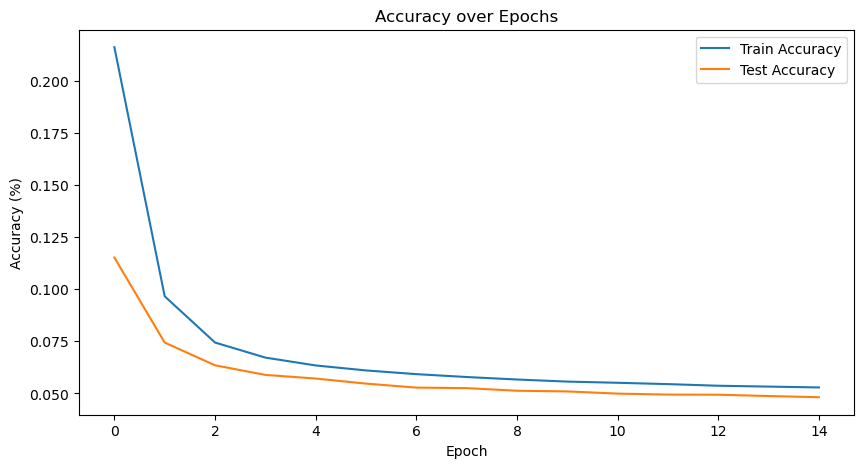

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(train_mse_history, label='Train Accuracy')
plt.plot(test_mse_history, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

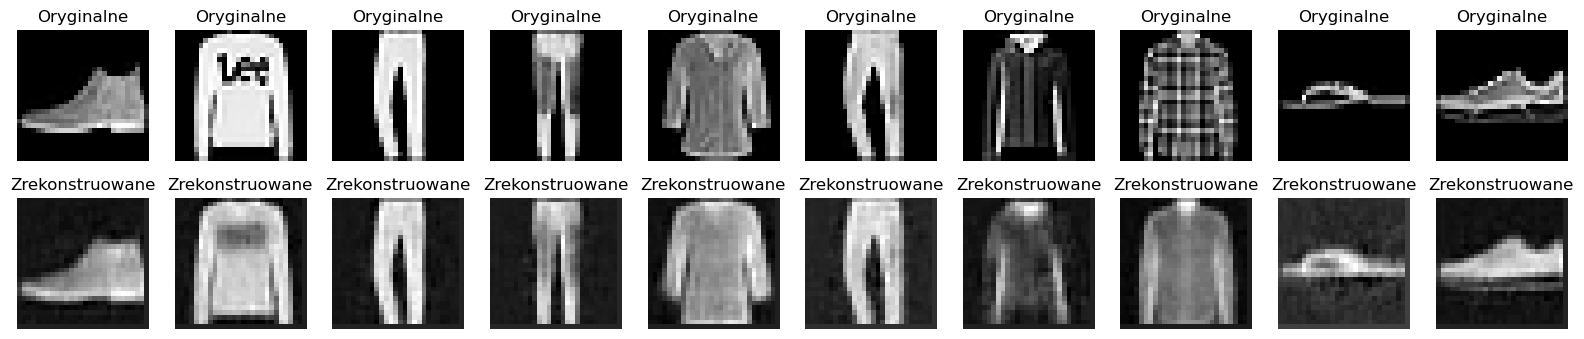

In [10]:
images, _ = next(iter(test_loader))
images = images.to(device)
outputs = model(images)

images = images.cpu().numpy()
outputs = outputs.cpu().detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))

for i in range(10):
    axes[0, i].imshow(np.squeeze(images[i]), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Oryginalne")

    axes[1, i].imshow(np.squeeze(outputs[i]), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Zrekonstruowane")

plt.show()